In [1]:
using SpecialFunctions
using QuantumOptics

function fidelity(ρ, σ)
    tr(sqrt(sqrt(ρ) * σ * sqrt(ρ)))^(1/2)
end

function R(n::Int64, m::Int64, ρ::Float64)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            n = big(n)
            k = big(k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end

function sample_across_unit_disk(f, discretization)
    x = y = Array(range(-1, 1, length=discretization))
    z = Array{typeof(f(0.,0.))}(UndefInitializer(), length(x), length(y))
    for (i, xx) in enumerate(x)
        for (j, yy) in enumerate(y)
            if xx^2 + yy^2 > 1
                if typeof(f(0.,0.)) == Tuple{Float64,Float64}
                    z[i, j] = (0.,0.)
                else
                    z[i, j] = 0.
                end
            else
                ρ = sqrt(xx^2 + yy^2)
                ϕ = atan(yy, xx)
                res = f(ρ, ϕ)
                z[i, j] = res
            end
        end
    end
    x, y, z
end

function unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t)
    """Each Zernike array is of arbitrary length, but they are ordered by order. The first is Z00 to Zn0 where
    n is the number of 0th order zernike polynomials being considered."""
    Pevens = []
    eventuples = []
    for (n, zeven) in enumerate(zernike_coefficients_even)
        neven = n - 1
        push!(Pevens, [zeven[i] * R(neven, i-1, ρ) for i in Array(range(1, length(zeven), step=1))])
    end
    for i in range(1, length(Pevens), step=1)
        rotationeven = - (i - 1) * ω * t
        total = 0
        for peven in Pevens
            if length(peven) >= i
                total += peven[i]
            end
        end    
        push!(eventuples, (i - 1, total, rotationeven))
    end

    Podds = []
    oddtuples = []
    for (n, zodd) in enumerate(zernike_coefficients_odd)
        nodd = n - 1
        push!(Podds, [zodd[i] * R(nodd, i-1, ρ) for i in Array(range(1, length(zodd), step=1))])
    end
    for i in range(1, length(Podds), step=1)
        rotationodd = - (i - 1) * ω * t
        total = 0
        for podd in Podds
            if length(podd) >= i
                total += podd[i]
            end
        end    
        push!(oddtuples, (i - 1, total, rotationodd))
    end
    eventuples, oddtuples
end

function infidelity_across_disk(F1, F2)
    function infidelity_polar(ρ, ϕ)
        ψ1 = F1(ρ, ϕ).data
        ψ2 = F2(ρ, ϕ).data
        1 - real(fidelity(ψ1, ψ2))
    end
end

function H_odf(ρ, ϕ, t, zernike_coefficients_even, zernike_coefficients_odd, U, ψ, μ, ω)
    eventuples, oddtuples = unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t)
    eventerm = oddterm = 0
    if length(eventuples) > 0
        eventerm = mapreduce(x->x[2]*cos(x[1]*ϕ + x[3]), +, eventuples)
    end
    if length(oddtuples) > 0
        oddterm = mapreduce(x->x[2]*sin(x[1]*ϕ + x[3]), +, oddtuples)
    end
    U * cos(-μ*t + ψ + eventerm + oddterm) 
end

function H_odf_RWA_small(ρ, ϕ, t, zernike_coefficients_even, zernike_coefficients_odd, U, ψ, ω, m)
    even, odd = unpack_zernike(zernike_even_coefficients, zernike_odd_coefficients, ρ, ω, t)
    even = even[m+1][2]
    odd = odd[m+1][2]
    U/2 * (even * sin(m*ϕ - ψ) - odd * cos(m*ϕ - ψ))
end    

function least_squares_solution(mat, y)
    inv(transpose(mat) * mat)*transpose(mat) * y
end

toarray(s::Union{Set, Array}) = [toarray.(s)...]
toarray(v::Number) = v

toarray (generic function with 2 methods)

In [2]:
max_order = 20
discretization = 50
zernike_samples = []
ordering = []
for n in range(0, max_order, step=1)
    for m in range(0, n, step=1)
        if (n-m)%2 == 0
            Zeven(ρ, ϕ) = R(n, m, ρ) * cos(m * ϕ)
            push!(zernike_samples, sample_across_unit_disk(Zeven, discretization)[3][:])
            push!(ordering, (n, m))
            if m !=0
                Zodd(ρ, ϕ) = R(n, m, ρ) * sin(m * ϕ)
                push!(zernike_samples, sample_across_unit_disk(Zodd, discretization)[3][:])
                push!(ordering, (n, -m))
            end
        end
    end
end
Z = reduce(hcat, zernike_samples);

In [3]:
σ1 = .1
σ2 = 1
amp = 1 # Used to make the small angle approximation work better.
function gaussian(σ1, σ2)
    function func(ρ, ϕ)
        x = ρ*cos(ϕ)
        y = ρ*sin(ϕ)
        amp * exp(-x^2/σ1^2 + -y^2/σ2^2)
    end
end
xx, yy, zz = sample_across_unit_disk(gaussian(σ1, σ2), discretization)
G = zz[:];

In [4]:
coefficients = least_squares_solution(Z, G)

231-element Array{BigFloat,1}:
  0.1057960262798804674235142456321838731186678821731525204935027734806724302355517
  4.478952039615099000234447784081621384900336587510756928696084220933919116399679e-17
  8.393763891137287781996486838209009571557469439900445514544102906610011410371941e-78
 -0.05926513939037899602540440890394586827286464633934171356695746805351232126137122
 -0.002615223925529078659918604382240707807999058704624984786465779291589230173132741
  2.396702813656314264285496131968418383784061533022840388337991437739429678650156e-80
  9.566347000698408865583191226786154820408937416597991645969411393418020941036889e-17
  9.458229384086417269190008013742089522051583696855785662827111035060852817201703e-78
  1.766567679888464994799806933487732594914747503468413112583717049603758661631641e-16
  1.655441343025489061919456583270931084780695235873326740588711127832731898010981e-77
  0.2119191124346479714853300463453172828252365013109029639361170714077739243125473
  0.37002748619834372

In [5]:
reconstruction = zeros(discretization*discretization)
for (i, zernike_sample) in enumerate(zernike_samples)
    reconstruction += coefficients[i] * zernike_sample
end

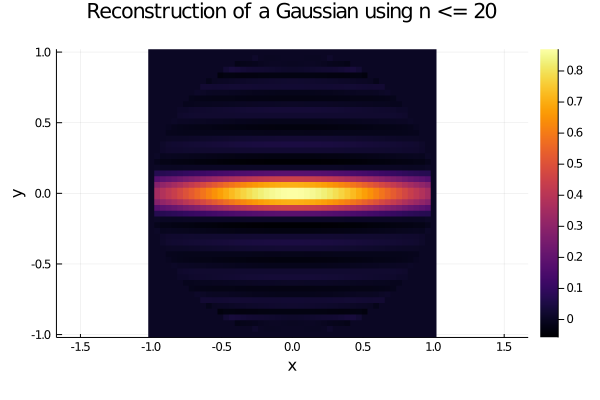

In [6]:
using Plots
plot(heatmap(xx, yy, reshape(reconstruction, (discretization, discretization))), aspectratio = true, xlabel="x", ylabel="y", title="Reconstruction of a Gaussian using n <= 20")

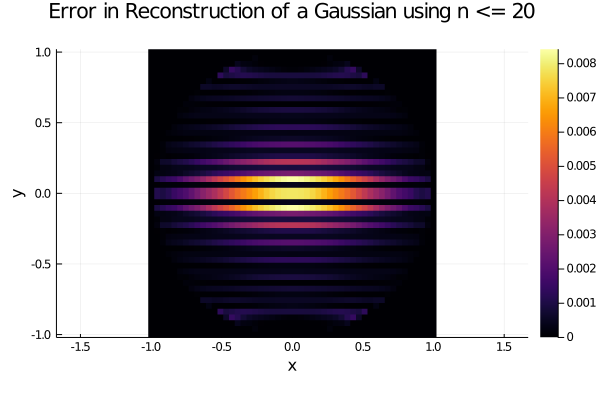

In [7]:
using Plots
diff = (sample_across_unit_disk(gaussian(σ1,σ2), discretization)[3] - reshape(reconstruction, (discretization, discretization))).*(sample_across_unit_disk(gaussian(σ1,σ2), discretization)[3] - reshape(reconstruction, (discretization, discretization)))
plot(heatmap(xx, yy, diff), aspectratio = true, xlabel="x", ylabel="y", title="Error in Reconstruction of a Gaussian using n <= 20")

In [8]:
xpoints = reshape(reconstruction, (discretization, discretization))[:,Int64(discretization/2)]

50-element Array{BigFloat,1}:
  0.0
  0.0003042914491442717935862174382321343111253534808663040072091871140689308153725292
 -0.00194192928039471926953691974096917205567039818929064915528521588429703048196332
  0.01019135620050515462379162498544583755010946102950213807648037137875834449638795
 -0.02981781677589089620549294425604642483844159429668819139234417018937812384539933
  0.01780543888357565408058151096505804927171690192559371034099318979851383664532251
  0.02301895790420852108306484097916022301675405531104894165650336386435223557107779
 -0.01611195265820855997930546325360858840924876015209688474829774355845084797831974
 -0.02762422471601595416307807585876443294302422552990308370012275431108471452161255
  0.002853793965776870822712376445505550820098451628995522545427758215203321651336609
  0.03025098268236025045442833851685220210059382428147232926488343337031417178425792
  0.01947323616862625849238932027668986766944033323002536095645180844036518278426323
 -0.0160926474244719663113

In [9]:
ypoints = reshape(reconstruction, (discretization, discretization))[Int64(discretization/2), :]

50-element Array{BigFloat,1}:
 0.0
 0.349318538212220093651423273297009963256811454977251153677079551196075100697645
 0.3817315385957789770384076683756836504615645252718785627151117468186582698542369
 0.4102529615199740992387292486326490312499896557616443019222281199060300131061573
 0.4376466141701959056838858346413360973699081003839879428397038256051004409905348
 0.4678403728024876123636968685778861852674552945210201077909144639816715626860733
 0.4983709315917934072072115441034245025900617327423128261153495960517673607764391
 0.5279519578942798106353477567964420318162266623490006365800739908087626390151875
 0.5572543153433191208951905306151970402364533218094013190319480957610446278238326
 0.5869352674317166735463436016627904400695995639310748475101476421856583822189687
 0.6167257135487209752946613172190894871647384618288865760450542080731476979868336
 0.6458700064533453928630586425375121307777500162829731289383006350179777692904513
 0.67383156652138805709246885172687431160240875716506

In [10]:
lookup = Dict(zip(ordering, coefficients));
zernike_even_coefficients = []
zernike_odd_coefficients = []
curr_even = []
curr_odd = []
for n in range(0, max_order, step=1)
    for m in range(0, n, step=1)
        if (n-m)%2 != 0
            push!(curr_even, 0)
            push!(curr_odd, 0)
        else
            if m == 0
                # I had a two here. I don't know if that is right or wrong - it was messing up the reconstruction.
                push!(curr_even, lookup[(n, m)])
                push!(curr_odd, lookup[(n, -m)])
            else
                push!(curr_even, lookup[(n, m)])
                push!(curr_odd, lookup[(n, -m)])
            end
        end
    end
    push!(zernike_even_coefficients, curr_even)
    push!(zernike_odd_coefficients, curr_odd)
    curr_even = []
    curr_odd = []
end

In [11]:
function sequential_exact_evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, θ, ω, b)
    """Apply all the zernike coefficients given, in order, for time T each."""
    orders = range(0, max(length(zernikeeven), length(zernikeodd)) - 1, step=1)
    function evaluator(ρ, ϕ)
        ψ = ψ0
        for order in orders
            print(order)
            μ = order * ω
            H(t, _) = H_odf_RWA_small(ρ, ϕ, t, zernikeeven, zernikeodd, U, θ, ω, order)*sigmaz(b), [], []
            _, ψ = @skiptimechecks timeevolution.master_dynamic(T, ψ, H)
            ψ = last(ψ)
        end
        ψ
    end
end

function gaussian_spin_profile(ρ, ϕ)
    ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
    H(t, _) = gaussian(σ1, σ2)(ρ, ϕ) * sigmaz(b), [], []
    evolution_time = π/2
    step_size = evolution_time/1
    T = [0.0:step_size:evolution_time;];
    _, ψ = timeevolution.master_dynamic(T, ψ0, H)
    last(ψ)
end

gaussian_spin_profile (generic function with 1 method)

In [12]:
Γ = 1/62
ω = 2*π*180E3
θ = -π/2;

In [13]:
b = SpinBasis(1//2)
ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
evolution_time =  50E-6
U = π/(evolution_time)
step_size = evolution_time
T = [0.0:step_size:evolution_time;];
sequential_exact_evolution = sequential_exact_evolution_evaluator_factory(ψ0, T, zernike_even_coefficients, zernike_odd_coefficients, U, θ, ω, b)

(::var"#evaluator#14"{Ket{SpinBasis{1//2,Int64},Array{Complex{Float64},1}},Array{Float64,1},Array{Any,1},Array{Any,1},Float64,Float64,Float64,SpinBasis{1//2,Int64},StepRange{Int64,Int64}}) (generic function with 1 method)

In [14]:
using Plots
max_ρ = 1
min_ρ = .0
len = 20
ρs = range(min_ρ, max_ρ, step=max_ρ/len)
angle = 0
target = [Real.(expect(sigmax(b), gaussian_spin_profile(ρ, angle))) for ρ in ρs]
ys = [Real.(expect(sigmax(b), sequential_exact_evolution(ρ, angle))) for ρ in ρs];

012345678910111213141516171819200123456789101112131415161718192001234567891011121314151617181920012345678910111213141516171819200123456789101112131415161718192001234567891011121314151617181920012345678910111213141516171819200123456789101112131415161718192001234567891011121314151617181920012345678910111213141516171819200123456789101112131415161718192001234567891011121314151617181920012345678910111213141516171819200123456789101112131415161718192001234567891011121314151617181920012345678910111213141516171819200123456789101112131415161718192001234567891011121314151617181920012345678910111213141516171819200123456789101112131415161718192001234567891011121314151617181920

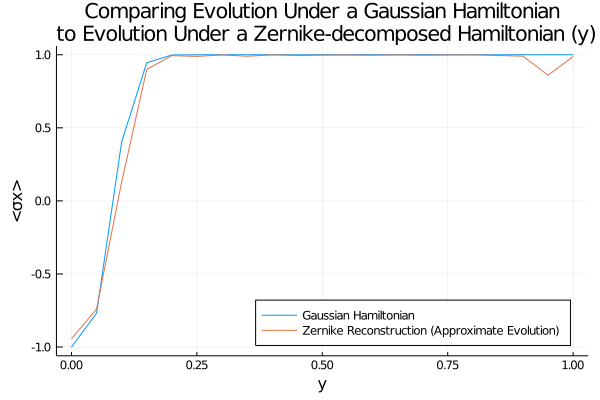

In [15]:
plot(ρs, [target, ys], label=["Gaussian Hamiltonian" "Zernike Reconstruction (Approximate Evolution)"], legend=:bottomright, ylabel="<σx>", xlabel="y", title="Comparing Evolution Under a Gaussian Hamiltonian\n to Evolution Under a Zernike-decomposed Hamiltonian (y)")

In [16]:
using Plots
max_ρ = 1
min_ρ = .0
len = 20
ρs = range(min_ρ, max_ρ, step=max_ρ/len)
angle = -π/2
target2 = [Real.(expect(sigmax(b), gaussian_spin_profile(ρ, angle))) for ρ in ρs]
y2s = [Real.(expect(sigmax(b), sequential_exact_evolution(ρ, angle))) for ρ in ρs];

012345678910111213141516171819200123456789101112131415161718192001234567891011121314151617181920012345678910111213141516171819200123456789101112131415161718192001234567891011121314151617181920012345678910111213141516171819200123456789101112131415161718192001234567891011121314151617181920012345678910111213141516171819200123456789101112131415161718192001234567891011121314151617181920012345678910111213141516171819200123456789101112131415161718192001234567891011121314151617181920012345678910111213141516171819200123456789101112131415161718192001234567891011121314151617181920012345678910111213141516171819200123456789101112131415161718192001234567891011121314151617181920

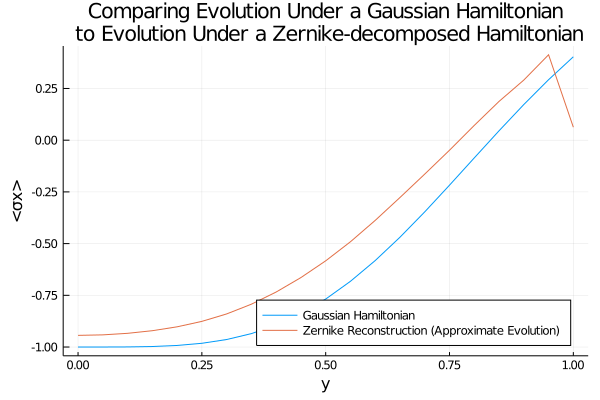

In [17]:
plot(ρs, [target2, y2s], label=["Gaussian Hamiltonian" "Zernike Reconstruction (Approximate Evolution)"], legend=:bottomright, ylabel="<σx>", xlabel="y", title="Comparing Evolution Under a Gaussian Hamiltonian\n to Evolution Under a Zernike-decomposed Hamiltonian")

In [18]:
ρs = range(min_ρ, max_ρ, step=max_ρ/20)

0.0:0.05:1.0

In [19]:
function disk_recon(ρ, ϕ)
    reconstruct(ρ, ϕ, zernike_even_coefficients, zernike_odd_coefficients)
end
xx, yy, zz = sample_across_unit_disk(disk_recon, discretization)


LoadError: UndefVarError: reconstruct not defined

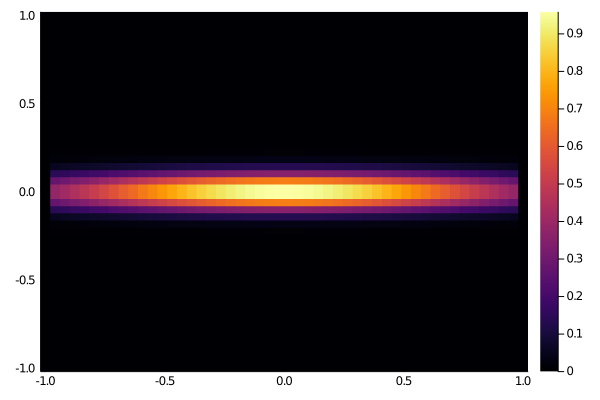

In [20]:
using Plots
plot(heatmap(xx, yy, zz))

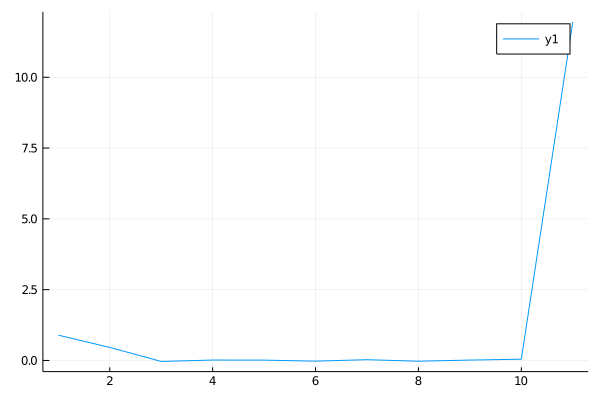

In [21]:
function reconstruct(ρ, ϕ, zernike_even_coefficients, zernike_odd_coefficients)
    total = 0
    for (n, array) in enumerate(zernike_even_coefficients)
        for (i, el) in enumerate(array)
            total += el*R(n-1, i-1, ρ)*cos((i-1)*ϕ)
        end
    end
    for (n, array) in enumerate(zernike_odd_coefficients)
        for (i, el) in enumerate(array)
            total += el*R(n-1, i-1, ρ)*sin((i-1)*ϕ)
        end
    end
    total
end
ρs = range(min_ρ, max_ρ, step=max_ρ/10)
plot([reconstruct(ρ, 0, zernike_even_coefficients, zernike_odd_coefficients) for ρ in ρs])